###  AULA 3 -> LEITURA DE DADOS OBSERVACONAIS COM O PANDAS.

In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [2]:
# abrindo o local dos dados
os.chdir('/home/gustavo/Documentos/python_aulas/dados/boia_fortaleza')

#### leitura e checagem

In [3]:
# lista das colunas que eu quero importar
colunms = ['yyyy','mm', 'dd', 'hour',"HS","Tp","H_max","Mn_dir"] 

# carregamento do dado
dado = pd.read_csv('dados_boia.csv',delimiter=',',usecols=colunms)

In [4]:
dado.describe()

,yyyy,mm,dd,hour,HS,H_max,Tp,Mn_dir
count,7087.000000,7087.000000,7087.000000,7087.000000,7087.000000,7087.000000,7087.000000,7087.000000
mean,2016.879357,6.688726,15.887823,12.755468,-27104.379077,-27103.640319,-27099.311951,-27038.794271
std,0.325735,3.512675,8.932555,6.923081,44454.180225,44454.630749,44457.270446,44494.186642
min,2016.000000,1.000000,1.000000,0.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000
25%,2017.000000,4.000000,8.000000,8.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000
50%,2017.000000,7.000000,16.000000,11.000000,1.470000,2.360000,6.500000,78.000000
75%,2017.000000,10.000000,24.000000,20.000000,1.800000,2.920000,9.500000,108.000000
max,2017.000000,12.000000,31.000000,23.000000,19.710000,20.380000,25.400000,372.000000


In [5]:
# excluindo os valores que sao nan's
dado[dado==-99999.000000] = np.NaN

#### filtragem

In [6]:
tempo = (dado.yyyy.astype(str)+'-'+dado.mm.astype(str)
         +'-'+dado.dd.astype(str)+' '+dado.hour.astype(str)+':'+'00')

In [7]:
tempo #string format

0       2016-11-16 20:00
1       2016-11-16 20:00
2       2016-11-16 20:00
3       2016-11-16 20:00
4       2016-11-16 23:00
              ...       
7082     2017-12-3 20:00
7083     2017-12-3 21:00
7084     2017-12-3 22:00
7085     2017-12-3 22:00
7086      2017-12-4 0:00
Length: 7087, dtype: object

In [8]:
tempo_datetime = [dt.datetime.strptime
                  (iterador,'%Y-%m-%d %H:%M') for iterador in tempo]

tempo = mdates.date2num(tempo_datetime)
del tempo_datetime

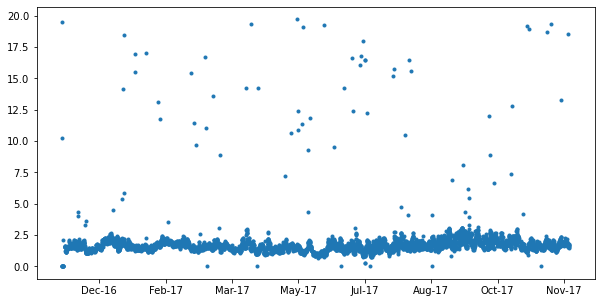

In [9]:
fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(tempo,dado.HS,'.')
myFmt = mdates.DateFormatter("%b-%y")# formato da data
ax.xaxis.set_major_formatter(myFmt)# setando o formato



In [10]:
def filter_mean(values):
    """ 
    filtro para remover valores fora do intervalo
    media +- 2*std. Ref: Emery and Thomson, 2014.
    obs: se usada com angulos, a função pode fornecer uma
    limpeza imprecisa.
    """
    
    import numpy as np
    
    values = np.array(values)
    
    mean = np.nanmean(values)
    
    std = np.nanstd(values)
    
    idx = [(values<mean-2*std)|(values>mean+2*std)]
    
    values[idx] = np.NaN
    
    return values
    
    

In [11]:
Hs_filtered = filter_mean(dado.HS)

H_max_filtered = filter_mean(dado.H_max)

Mn_dir_filtered = filter_mean(dado.Mn_dir)

rc = {"Tempo":tempo,"Hs":Hs_filtered,
      "Hmax":H_max_filtered,"Direction":Mn_dir_filtered,"Tp":dado.Tp}

<ipython-input-10-042eefa6cb4f>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values[idx] = np.NaN


In [12]:
rc = pd.DataFrame(rc)

In [13]:
# interpolando dados para preencher os intervalos 
# vazios

rc.Hs.interpolate(method='linear',inplace=True)
rc.Hmax.interpolate(method='linear',inplace=True)
rc.Direction.interpolate(method='linear',inplace=True)
rc.Tp.interpolate(method='linear',inplace=True)

In [14]:
# removendo variaveis inuteis

del Hs_filtered, H_max_filtered , Mn_dir_filtered

#### plotagem da serie completa

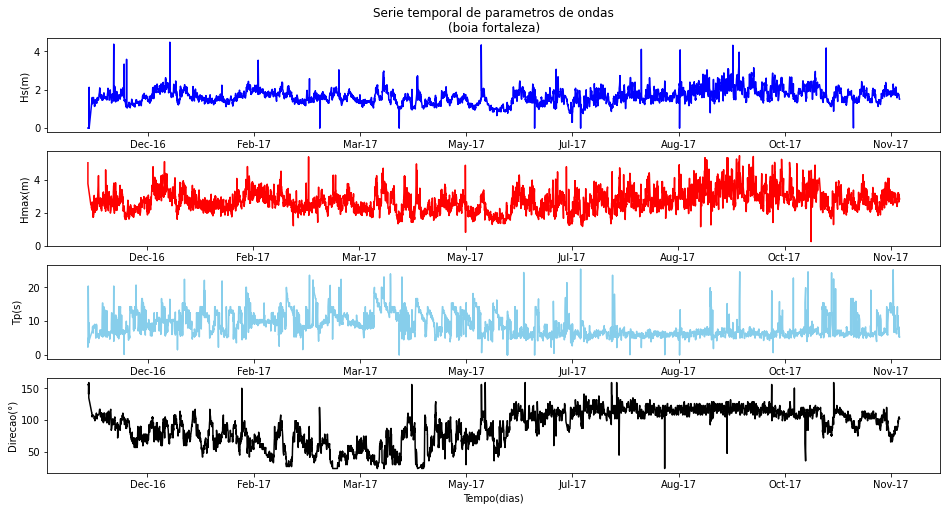

In [15]:
# figura tipo subplots com 4 eixos, 16x8
fig, (ax1, ax2 ,ax3, ax4) = plt.subplots(4,figsize=(16,8))

#formato da data
myFmt = mdates.DateFormatter('%b-%y')


ax1.plot(rc.Tempo,rc.Hs,'-b')
ax2.plot(rc.Tempo,rc.Hmax,'-r')
ax3.plot(rc.Tempo,rc.Tp,'-',color='skyblue')
ax4.plot(rc.Tempo,rc.Direction,'-',color='black')

# label de y
ax1.set_ylabel('Hs(m)')
ax2.set_ylabel('Hmax(m)')
ax3.set_ylabel('Tp(s)')
ax4.set_ylabel('Direcao(°)')

#setando o formato das datas no plot
ax1.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_formatter(myFmt)
ax3.xaxis.set_major_formatter(myFmt)
ax4.xaxis.set_major_formatter(myFmt)

#setando o titulo e label do eixo x
ax4.set_xlabel('Tempo(dias)')
ax1.set_title('Serie temporal de parametros de ondas\n(boia fortaleza)');


#### Plotando uma rosa dos ventos com os dados de ondas filtrados

In [25]:
# this sets the legend scale
#from windrose import WindroseAxes
#ax = WindroseAxes.from_ax()
#ax.set_theta_zero_location("N") #setando o zero para o norte
#ax.set_theta_direction(-1) #sentido de rotacao
#ax.bar(rc.Direction,rc.Hs,blowto=False,normed=True,bins=range(0,360,45))
#ax.set_yticks(np.arange(10, 60, step=10))
#ax.set_yticklabels(np.arange(10, 60, step=10))
#plt.show()

In [16]:
from windrose import WindroseAxes

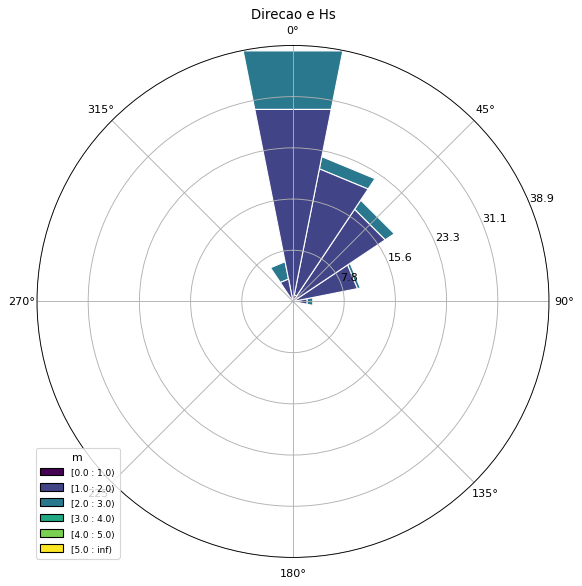

In [20]:
ax = WindroseAxes.from_ax()
ax.set_theta_zero_location("N") #setando o zero para o norte
ax.set_theta_direction(-1) #sentido de rotacao

intervalo = np.arange(0, rc.Hs.max()+1,1) #legend scale
viridis = plt.get_cmap('viridis') #colors scale
ax.bar(rc.Direction-21,rc.Hs, normed=True, bins=intervalo,
	opening=1, edgecolor='white',cmap=viridis)


ax.set_legend(title='m') #legend
plt.title('Direcao e Hs') #title
plt.show()